**Install libraries**

In [ ]:
!pip install sentence-transformers scipy
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('gubartz/st_all_mini_science')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

**Read the dataset**

In [ ]:
import pandas as pd

file_path = 'collection_with_abstracts.csv'
df = pd.read_csv(file_path, na_values=['', 'NA'])

print(len(df))


11450


# Task 1: Find the relevant papers

In [ ]:
from sentence_transformers import util
import pandas as pd

# Reference embedding for comparison
reference_embeddings = model.encode('deep learning', convert_to_tensor=True)

def calculate_similarity(paper_text, reference_embeddings):
  paper_embedding = model.encode(paper_text, convert_to_tensor=True)

  similarities = util.cos_sim(paper_embedding, reference_embeddings)
  #print("similarities", similarities)

  max_similarity = similarities.item()

  is_relevant = max_similarity >= threshold
  return is_relevant, max_similarity

# Set the similarity threshold (decided on manual inspection)
threshold = 0.8
relevant_papers = []

for index, row in df.iterrows():
  paper_text = f"{row['Title']} {row['Abstract']}" if 'Abstract' in row else row['Title']
  is_relevant, similarity_score = calculate_similarity(paper_text, reference_embeddings)

  if is_relevant:
    relevant_papers.append(row)

# Convert relevant papers to a DataFrame
relevant_df = pd.DataFrame(relevant_papers)
print("Number of relevant papers:", len(relevant_df))


Number of relevant papers: 7927


# Task 2: Classify the relevant papers into mentioned categories

In [ ]:
from transformers import pipeline
from tqdm import tqdm

candidate_labels = ['text mining', 'computer vision']
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

# All the thresholds were determined based on manual inspection of LM for this
# zero shot classification task over several examples

def classify_entry(text):
  result = classifier(text, candidate_labels)

  scores = {label: score for label, score in zip(result['labels'], result['scores'])}

  # if produced scores for both classes is high then likely it consists of both methods
  if scores['text mining'] > 0.4 and scores['computer vision'] > 0.4:
    return 'both'

  elif scores['text mining'] > scores['computer vision'] and scores['text mining']>0.4:
    return 'text mining'

  elif scores['computer vision'] > scores['text mining'] and scores['computer vision']>0.4:
    return 'computer vision'

  else:
    return 'other'

tqdm.pandas()
# replace the Asbtract with the Title, just incase the abstract is missing from the paper
# only for the classification purpose

relevant_df['Abstract'] = relevant_df['Abstract'].fillna(relevant_df['Title'])
relevant_df['Label'] = relevant_df['Abstract'].progress_apply(classify_entry)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 7927/7927 [26:36<00:00,  4.96it/s]


# Task 3: Extract and report the name of the scientific method used in the relevant paper

In [ ]:
import re

# Helper method for final cleanup
# of bert tokens produced by pipeline output

def clean_bert_tokens(tokens):
    cleaned_tokens = []

    for token in tokens:
        # Remove '##' from the token (if it's a continuation of the previous word)
        cleaned_token = token.replace("##", "")

        cleaned_tokens.append(cleaned_token)

    final_tokens = []

    for token in cleaned_tokens:
        token = ' '.join(token.split())
        final_tokens.append(token)

    final_tokens_string = ", ".join(final_tokens)

    return final_tokens_string

# Example demonstrating
tokens = ['data mining', 'dutch lipid clinic network ( dl ##cn ) scores', 'mono ##genic inheritance', 'modern data mining methods']
processed_tokens = clean_bert_tokens(tokens)
print(processed_tokens)


data mining, dutch lipid clinic network ( dl cn ) scores, mono genic inheritance, modern data mining methods


In [ ]:
from transformers import pipeline
from tqdm import tqdm
import pandas as pd
from transformers import pipeline
import pandas as pd
import nltk
from tqdm import tqdm
import logging

# Initialize logging for error tracking
logging.basicConfig(filename='processing_errors.log', level=logging.ERROR)

nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Load the pipeline
pipe = pipeline("token-classification", model="Yamei/scibert_scivocab_uncased_NER_VISBank", device=0)

# Helper function to process the extracted entities
def process_entities(entities):
    methods = []
    current_method = []

    # Loop through each entity in the tagged list
    for entity in entities:
        if entity['entity'] == 'B_METHOD':
            # If there's an ongoing method, save it before starting a new one
            if current_method:
                methods.append(" ".join(current_method))
                current_method = []
            # Start a new method with the first word in the method name
            current_method.append(entity['word'])
        elif entity['entity'] == 'I_METHOD' and current_method:
            # Append to current method if it's part of a method continuation
            current_method.append(entity['word'])
        else:
            # If it's not part of a method, save any ongoing method and reset
            if current_method:
                methods.append(" ".join(current_method))
                current_method = []

    # Capture any method left at the end of the list
    if current_method:
        methods.append(" ".join(current_method))

    return methods

def chunk_text(text, max_length=512):
    """
    Split the text into chunks with a maximum length in tokens,
    based on approximate word count since token count may vary.
    """
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []

    for sentence in sentences:
        # Estimate token count by word count (assuming avg 10 tokens per word)
        if len(" ".join(current_chunk + [sentence]).split()) * 10 < max_length:
            current_chunk.append(sentence)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

# Function to apply the pipeline with error handling and text chunking
def call_pipe(row):
    text = row['Abstract']
    index = row.name
    methods = []

    try:
        # Break the text into chunks if needed
        chunks = chunk_text(text)

        # Process each chunk and accumulate results
        for chunk in chunks:
            entities = pipe(chunk)
            methods.extend(process_entities(entities))

    except Exception as e:
        print(f"Error processing row {index}: {e}")
        return ["Error"]

    # Return unique methods only
    return clean_bert_tokens(list(set(methods)))

tqdm.pandas()
relevant_df['Top_Methods'] = relevant_df.progress_apply(call_pipe, axis=1)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
 54%|█████▍    | 4288/7927 [05:13<04:13, 14.34it/s]

Error processing row 6101: The size of tensor a (602) must match the size of tensor b (512) at non-singleton dimension 1


100%|██████████| 7927/7927 [09:53<00:00, 13.35it/s]


In [ ]:
print(relevant_df.head(5))
relevant_df.to_csv('filtered_relevant_papers.csv', index=False)
print("Filtered papers saved to 'filtered_relevant_papers.csv'")

       PMID                                              Title  \
0  39435445  Editorial: The operationalization of cognitive...   
3  39367648  An initial game-theoretic assessment of enhanc...   
4  39363262  Truncated M13 phage for smart detection of E. ...   
5  39287522  AI for Multistructure Incidental Findings and ...   
7  39275979  Setting up an institutional OMERO environment ...   

                                             Authors  \
0  Winter M, Probst T, Tallon M, Schobel J, Pryss R.   
3  Fatemi MY, Lu Y, Diallo AB, Srinivasan G, Azhe...   
4  Yuan J, Zhu H, Li S, Thierry B, Yang CT, Zhang...   
5  Marcinkiewicz AM, Buchwald M, Shanbhag A, Bedn...   
7  Jannasch A, Tulok S, Okafornta CW, Kugel T, Bo...   

                                            Citation      First Author  \
0  Front Neurosci. 2024 Oct 7;18:1501636. doi: 10...          Winter M   
3  Brief Bioinform. 2024 Sep 23;25(6):bbae476. do...         Fatemi MY   
4  J Nanobiotechnology. 2024 Oct 3;22(1):599

# Plot the frequency label

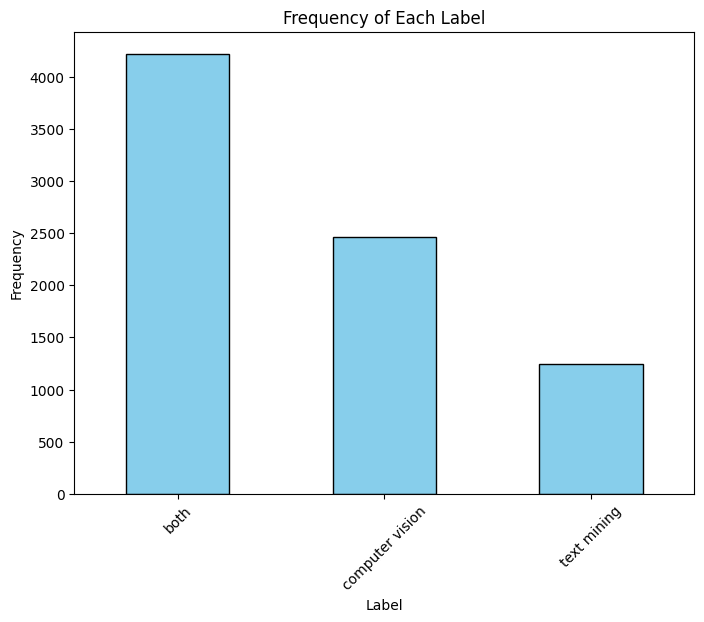

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = relevant_df['Label'].value_counts()

# Plot the frequencies
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Frequency of Each Label")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()
